In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
#@title Default title text
import re
from collections import Counter
import time

%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
from matplotlib import pyplot
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

from urllib.request import urlretrieve
import requests
from os.path import isfile, isdir
import zipfile

!pip install adjustText
from adjustText import adjust_text

if not os.path.exists('MODEL'):
    os.makedirs('MODEL')

In [ ]:
#@title Default title text
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def plot(embeddings, labels):
  texts = []
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pyplot.figure(figsize=(30, 30))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pyplot.scatter(x, y)
    #pyplot.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   #ha='right', va='bottom')
    texts.append(pyplot.text(x, y, label)) #Creates better plots but takes a long time. To save time, comment this, and uncomment the pyplot.annotate line
  adjust_text(texts , arrowprops=dict(arrowstyle='->', color='red'))
  pyplot.show()

file_id = '1fe5WTpjAaoKivd2XA1hvU0TmVXTkwGK3'

download_file_from_google_drive(file_id, 'model.zip')

file_id = '1w3uSNtc1srNaWoRHwbUE9o3baokloh9U'

download_file_from_google_drive(file_id, 'books.csv')

# UNZIP ZIP
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('model.zip', 'r')
zip_ref.extractall('MODEL/')
zip_ref.close()

b = pd.read_csv( 'books.csv' )
b.head(30)
bookDictionary = b.set_index('book_id').to_dict()['title']
bookDictionary[5]
AuthorDictionary = b.set_index('book_id').to_dict()['authors']

Uncompressing zip file


In [ ]:
#@title Default title text
with tf.Session() as sess:
  saver = tf.train.import_meta_graph('./MODEL/bookVec.ckpt.meta')
  saver.restore(sess, './MODEL/bookVec.ckpt' )

  embeddings = tf.get_default_graph().get_tensor_by_name('embeddings:0') #Getting regular embeddings
  softmax_weights = tf.get_default_graph().get_tensor_by_name('softmax_weights:0') #Get softmax embeddings
  
  normSM = tf.sqrt(tf.reduce_sum(tf.square(softmax_weights), 1, keepdims=True))
  normalized_embeddingsSM = softmax_weights / normSM
  
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  
  final_embeddings = normalized_embeddings.eval()
  final_embeddingsSM = normalized_embeddingsSM.eval()

INFO:tensorflow:Restoring parameters from ./MODEL/bookVec.ckpt


In [ ]:
#Use this code to get the book_id for any book using the title, or a word in the title. 
#The search is case sensitive. All words in a title tend to be capitalized. 

searchPhrase = 'The Notebook'
lines = []
for i in bookDictionary:
  if type(bookDictionary[i]) is str:
    if searchPhrase in bookDictionary[i] :
        lines.append(i)
for j in lines:
  print( bookDictionary[j], AuthorDictionary[j], ' | Book ID: ', j  )

The Notebook (The Notebook, #1) Nicholas Sparks  | Book ID:  44
The Wedding (The Notebook, #2) Nicholas Sparks  | Book ID:  686


In [ ]:
#Use this code to get the book_id for any book using the authur name, using their full name, first name, or last name.  
#The search is case sensitive,  capitalize the first letter of any name. 

authorPhrase = 'George Saunders'
lines = []
for i in AuthorDictionary:
  if type(AuthorDictionary[i]) is str:
    if authorPhrase in AuthorDictionary[i] :
        lines.append(i)
for j in lines:
  print( bookDictionary[j], ' | ', AuthorDictionary[j], ' | Book ID: ', j  )

print(' ')

authorPhrase = 'Sullivan'
lines = []
for i in AuthorDictionary:
  if type(AuthorDictionary[i]) is str:
    if authorPhrase in AuthorDictionary[i] :
        lines.append(i)
for j in lines:
  print( bookDictionary[j], ' | ', AuthorDictionary[j], ' | Book ID: ', j  )

print(' ')

authorPhrase = 'Jorge Luis Borges'
lines = []
for i in AuthorDictionary:
  if type(AuthorDictionary[i]) is str:
    if authorPhrase in AuthorDictionary[i] :
        lines.append(i)
for j in lines:
  print( bookDictionary[j], ' | ', AuthorDictionary[j], ' | Book ID: ', j  )

  

Tenth of December  |  George Saunders  | Book ID:  2316
CivilWarLand in Bad Decline  |  George Saunders  | Book ID:  6892
Pastoralia  |  George Saunders  | Book ID:  7008
Lincoln in the Bardo  |  George Saunders  | Book ID:  9392
 
Theft of Swords (The Riyria Revelations, #1-2)  |  Michael J. Sullivan  | Book ID:  2871
Rise of Empire (The Riyria Revelations, #3-4)  |  Michael J. Sullivan  | Book ID:  3725
Heir of Novron (The Riyria Revelations, #5-6)  |  Michael J. Sullivan  | Book ID:  3798
Maine  |  J. Courtney Sullivan  | Book ID:  4164
The Crown Tower (The Riyria Chronicles, #1)  |  Michael J. Sullivan  | Book ID:  5848
Private Games (Private #3)  |  James Patterson, Mark T. Sullivan  | Book ID:  6294
The Engagements  |  J. Courtney Sullivan  | Book ID:  6958
The Rose and the Thorn (The Riyria Chronicles, #2)  |  Michael J. Sullivan  | Book ID:  7816
Commencement   |  J. Courtney Sullivan  | Book ID:  8525
The Crown Conspiracy (The Riyria Revelations, #1)  |  Michael J. Sullivan  |

In [ ]:
# Tenth of December  |  George Saunders  | Book ID:  2316
# CivilWarLand in Bad Decline  |  George Saunders  | Book ID:  6892
# Ficciones  |  Jorge Luis Borges, Anthony Kerrigan, Anthony Bonner  | Book ID:  3124
# Labyrinths:  Selected Stories and Other Writings  |  Jorge Luis Borges, Donald A. Yates, James E. Irby, André Maurois  | Book ID:  4336

JaneA = (np.take(final_embeddings, 2316, axis=0) 
        + np.take(final_embeddings, 6892, axis=0) 
        + np.take(final_embeddings, 3124, axis=0)
        + np.take(final_embeddings, 4336, axis=0)   )
similarityJaneA = np.matmul(JaneA, np.transpose(final_embeddings))

nearestJaneA = (-similarityJaneA).argsort()[0:30]

for k in range(4, 30):
  print(bookDictionary[nearestJaneA[k]], AuthorDictionary[nearestJaneA[k]])

Infinite Jest David Foster Wallace
Blood Meridian, or the Evening Redness in the West Cormac McCarthy
The Crying of Lot 49 Thomas Pynchon
Consider the Lobster and Other Essays David Foster Wallace
A Visit from the Goon Squad Jennifer Egan
White Noise Don DeLillo
The Amazing Adventures of Kavalier & Clay Michael Chabon
The Sound and the Fury William Faulkner
2666 Roberto Bolaño
A Confederacy of Dunces John Kennedy Toole, Walker Percy
The Brief Wondrous Life of Oscar Wao Junot Díaz
Between the World and Me Ta-Nehisi Coates
Dubliners James Joyce, Jeri Johnson
A Supposedly Fun Thing I'll Never Do Again:  Essays and Arguments David Foster Wallace
If on a Winter's Night a Traveler Italo Calvino, William Weaver
The New York Trilogy Paul Auster, Art Spiegelman
The Unbearable Lightness of Being Milan Kundera, Michael Henry Heim
Pale Fire Vladimir Nabokov
Collected Fictions Jorge Luis Borges, Andrew Hurley
A Portrait of the Artist as a Young Man James Joyce, Seamus Deane
Cat's Cradle Kurt Vonneg

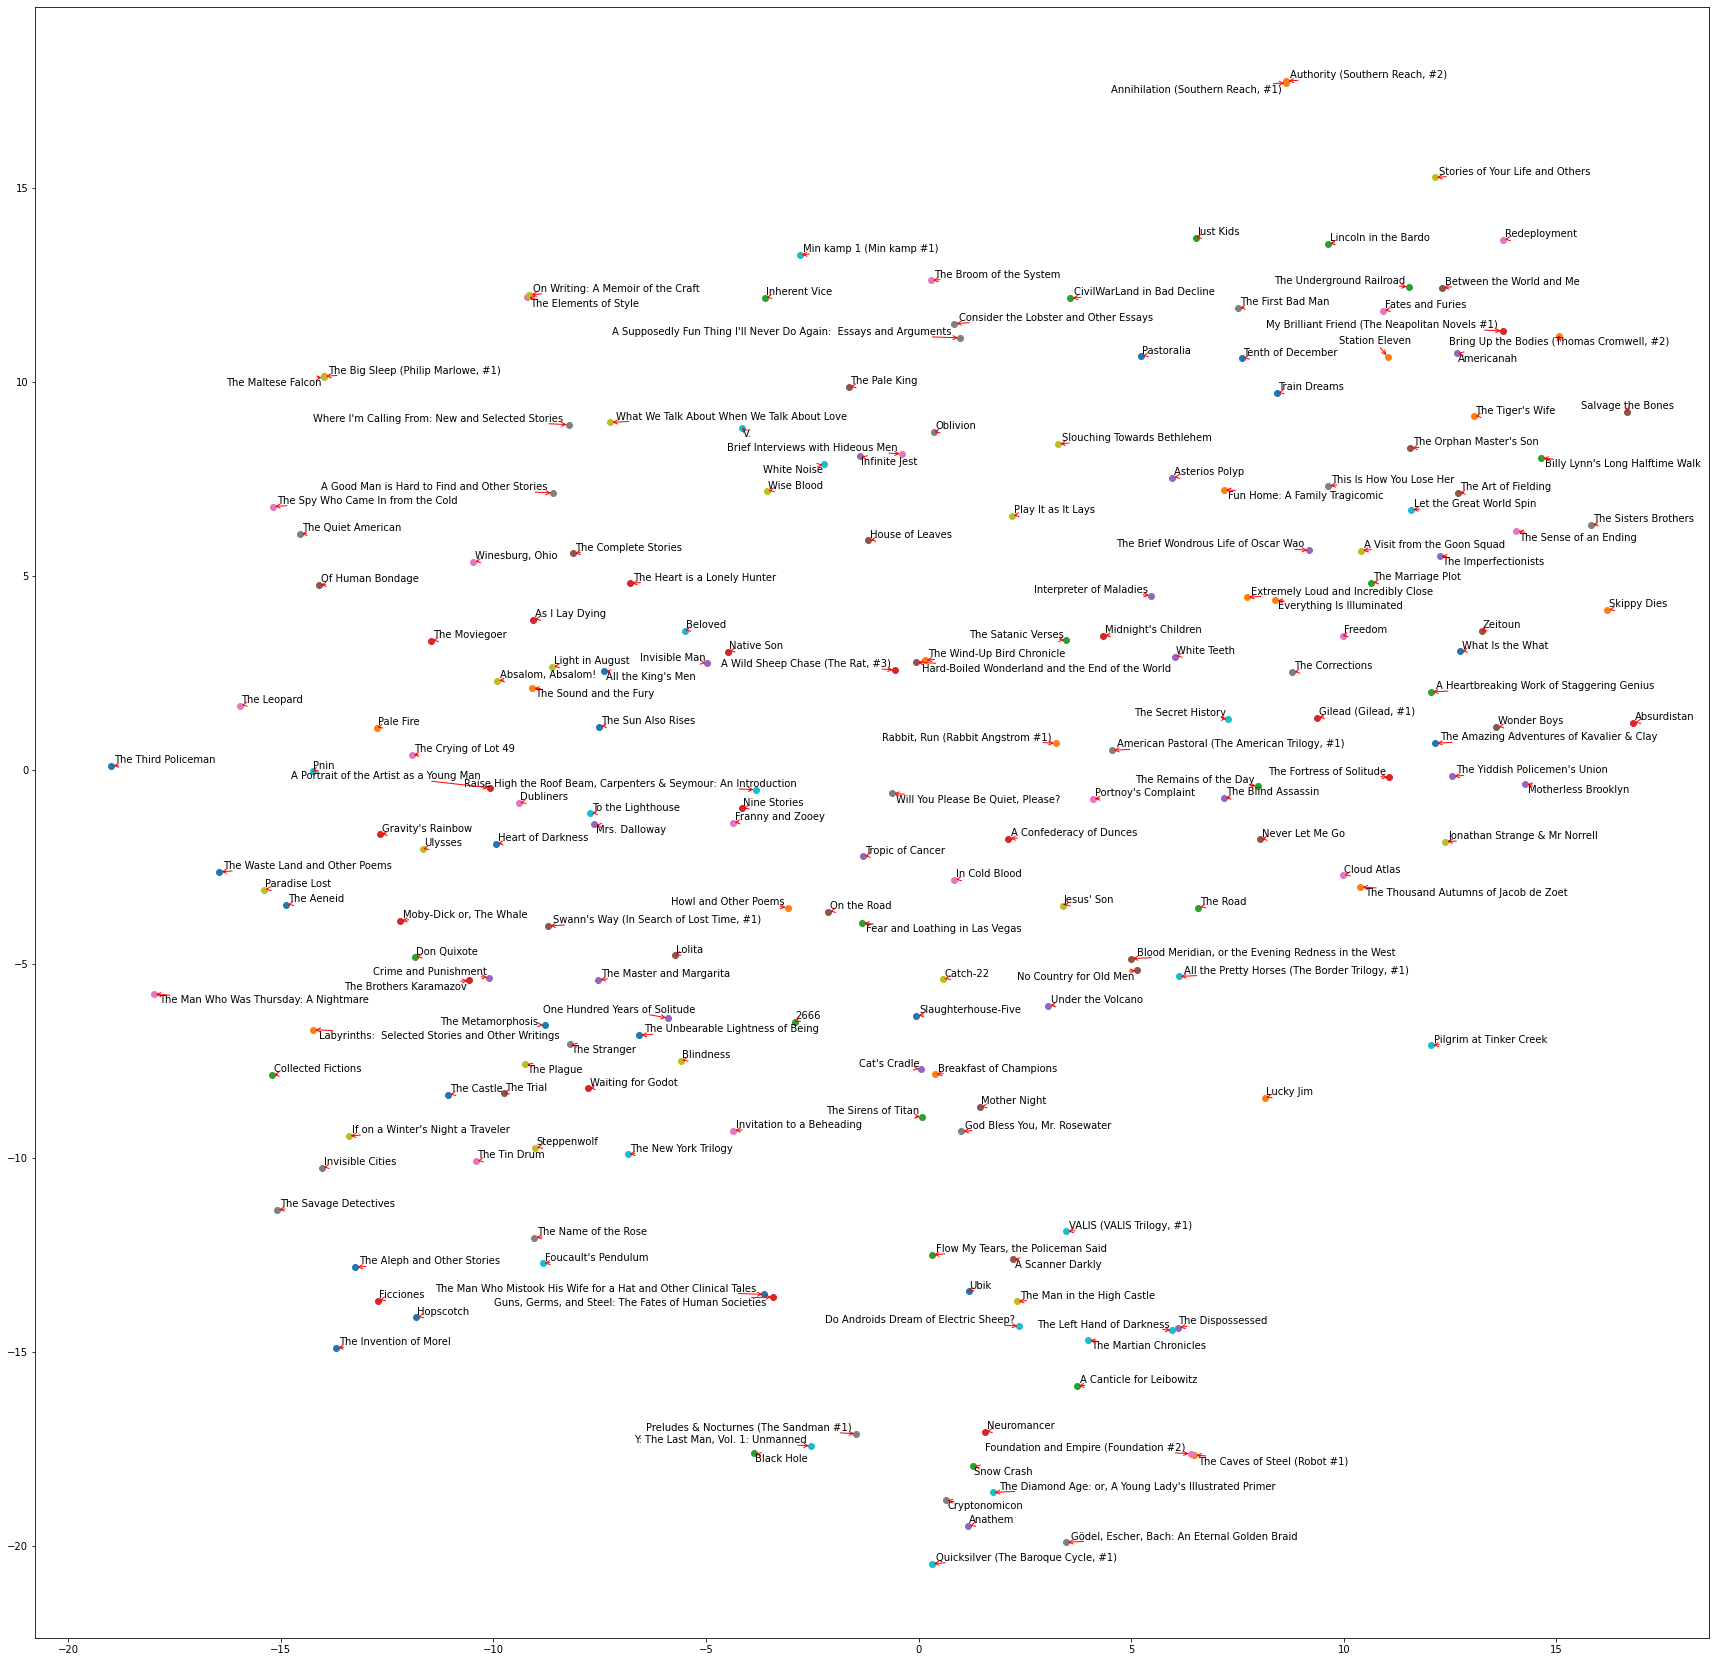

In [ ]:
NumberOfBooks = 200

nearestBooks = (-similarityJaneA).argsort()[0:NumberOfBooks]

for_TSNE = np.take(final_embeddings, nearestBooks, axis=0) 

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(for_TSNE)

# print(for_TSNE)
# print(tsne)

books = [bookDictionary[i] for i in nearestBooks]
plot(two_d_embeddings, books)